# Predicting Cross Selling Opportunities
#### Health Insurance Cross Selling

Author: Miguel Santana

#### Project Methodology
An insurance company provides health insurance to its customers. The client would like to build a model that predicts whether current customers would be interested in vehicle insurance provided by the company. The dataset includes customer demographic and vehicle information including gender, age, region, vehicle age, damage, policy premium and sourcing channel. 

This project will follow the OSEMN process: Obtain, Scrub, Explore, Model, Interpret. The Kaggle data set can be located [here.](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

# Obtain | Packages and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.style as style
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
sns.set_palette('rocket')

In [2]:
import plotly.express as px
# import cufflinks as cf
# cf.go_offline()

In [3]:
df = pd.read_csv('train.csv')

#### Data Explained

<img src='images/data.png'>

In [4]:
display(df.shape)
df.head(2)

(381109, 12)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


# Scrub | Data Cleaning
#### Missing Values

In [5]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Outliers

```Python
df.iplot(kind='box',title='Outlier Observation')
```

<img src='images/outlier.png'>

The ID columns will be dropped. There are a ton of outliers in the Annual Premium column.

#### Dropping Features / Data

In [6]:
df.drop(['id'],axis=1,inplace=True)

In [7]:
# dropping about 1 percent of the data
df = df[df['Annual_Premium'] < 75000]

# Exploratory Data Analysis
#### Class Imbalance

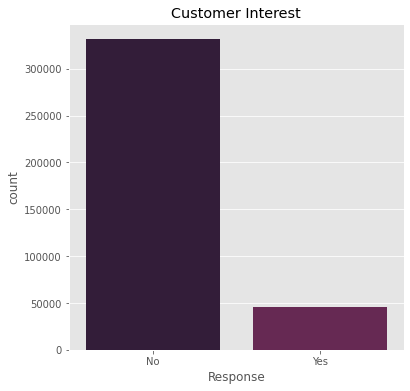

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, x='Response');
plt.title('Customer Interest')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()

#### Interest by Gender

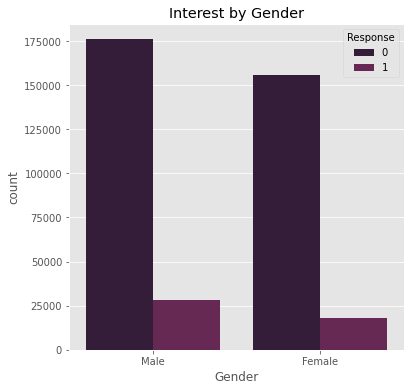

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(data=df,x='Gender',hue='Response');
plt.title('Interest by Gender');

#### Interest by Vehicle Age

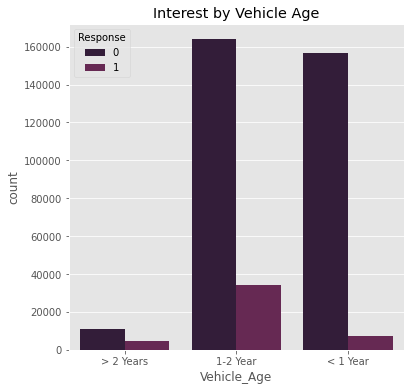

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(data=df,x='Vehicle_Age',hue='Response');
plt.title('Interest by Vehicle Age');

#### Multicollinearity

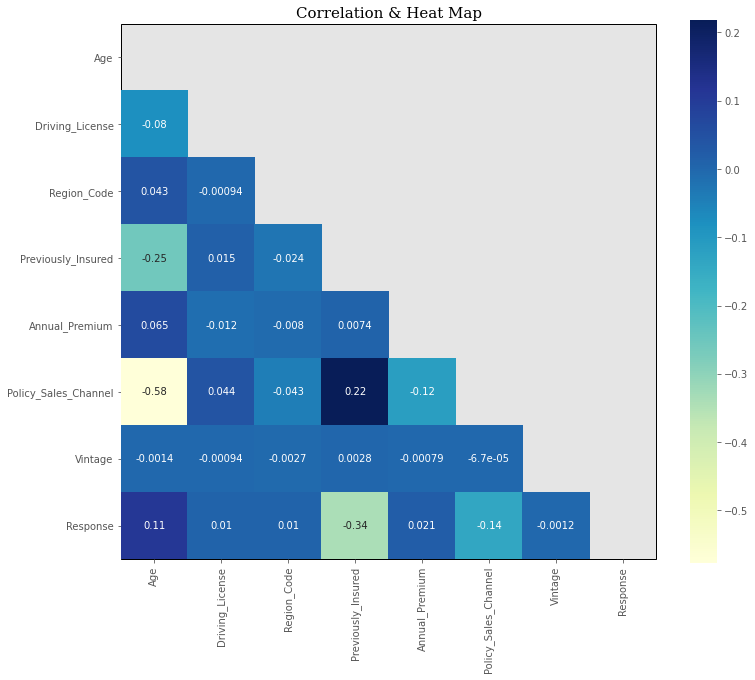

In [11]:
corr = df.corr() # analyzing correlation
fig, ax = plt.subplots(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='YlGnBu')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
ax.set_title('Correlation & Heat Map', fontsize=15, fontfamily='serif')
plt.show()

## Final Conversions
#### Converting Numerical Columns to Integers

In [12]:
cat_cols = df.select_dtypes('object').columns
num_cols = df.select_dtypes('number').columns

In [13]:
for col in num_cols:
    df[col] = df[col].astype(int)

#### Converting Categorical Columns

In [14]:
for col in cat_cols:
    display(pd.DataFrame(df[col].unique()))

,0
0,Male
1,Female


,0
0,> 2 Years
1,1-2 Year
2,< 1 Year


,0
0,Yes
1,No


In [15]:
dictvals = {'Yes':1,'No':0,'< 1 Year':1,'1-2 Year':2,'> 2 Years':3,
            'Male':1,'Female':0}
for col in cat_cols:
    df[col] = df[col].replace(dictvals)

# Model

In [16]:
# Modeling packages
from sklearn.metrics import silhouette_score
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### Principle Component Analysis

In [17]:
# reducing dimensionality / two columns
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df) # passing scaled data

In [18]:
# creating dataframe out of 2 component result
pca_df = pd.DataFrame(data = principal_comp, columns=['PCA1','PCA2'])

## K Means Clustering

In [19]:
scores = [] # elbow method
range_values = range(1,15)
for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_df)
    scores.append(kmeans.inertia_) # inertia is the WCSS parameter

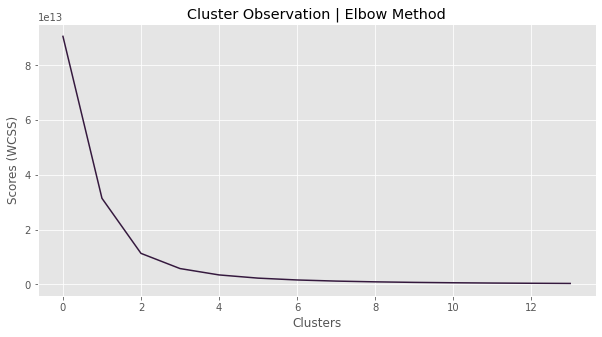

In [20]:
# cluster observation
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('Cluster Observation | Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Scores (WCSS)')
plt.show()

In [21]:
# 3 Clusters
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=101)
pca_df['Three_Clusters'] = km.fit_predict(pca_df)

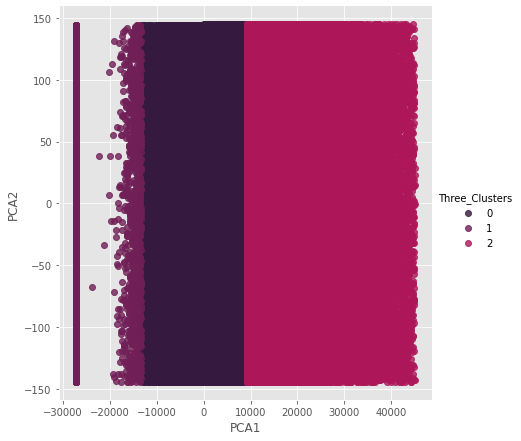

In [22]:
# cluster observation
sns.lmplot(x='PCA1', y='PCA2', data=pca_df, fit_reg=False, hue='Three_Clusters'
           ,size=6,aspect=1);

Pretty clear division, we'll add it to our analysis.

In [23]:
pca_df.head(2)

,PCA1,PCA2,Three_Clusters
0,10485.199504,62.708083,2
1,3567.202468,28.682340,0


In [24]:
# Create new dataframe | original with cluster ID
df2 = pd.concat([df,pca_df['Three_Clusters']],axis=1)

In [31]:
# dropping another 1 percent of data
df2.dropna(inplace=True)

# floats to ints
for col in num_cols:
    df2[col] = df2[col].astype(int)

## Pycaret Classification Model

In [33]:
import pycaret
import pycaret.preprocess as preprocess
from pycaret.datasets import get_data
from pycaret.classification import *
import pycaret.preprocess as preprocess

#### Imbalanced Model

```Python
clf = setup(data = df2,
            target = 'Response',
            session_id = 123, 
            numeric_features=['Gender','Vehicle_Age','Vehicle_Damage',
                              'Driving_License','Previously_Insured'])

compare_models()
```

In [ ]:
clf = setup(data = df2,
            target = 'Response',
            session_id = 123, 
            numeric_features=['Gender','Vehicle_Age','Vehicle_Damage',
                              'Driving_License','Previously_Insured'])

<img src='images/imbalancedmodel.png'>

While the results may look attractive, a useful model will be able to accurately classify customers in a balanced data set.

#### Balanced Model

In [41]:
clf2 = setup(data = df2, 
             target = 'Response', 
             session_id = 123, 
             fix_imbalance=True, 
             numeric_features=['Gender','Vehicle_Age','Vehicle_Damage', 
                               'Driving_License','Previously_Insured'])

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(374555, 12)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [42]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.8761,0.8536,0.0502,0.4453,0.0902,0.0670,0.1165,36.0452
1,Extreme Gradient Boosting,0.8741,0.8519,0.0623,0.4048,0.1080,0.0779,0.1194,11.9761
2,Light Gradient Boosting Machine,0.8713,0.8511,0.0787,0.3766,0.1300,0.0916,0.1255,0.9102
3,Random Forest Classifier,0.8549,0.7975,0.1885,0.3349,0.2412,0.1679,0.1764,0.9837
4,Extra Trees Classifier,0.8509,0.8275,0.2205,0.3345,0.2658,0.1867,0.1917,6.9979
5,Gradient Boosting Classifier,0.8318,0.8417,0.3756,0.3337,0.3534,0.2571,0.2577,45.3334
6,Decision Tree Classifier,0.8205,0.6027,0.3144,0.2869,0.3000,0.1973,0.1976,1.3498
7,Ada Boost Classifier,0.8017,0.8349,0.5532,0.3202,0.4054,0.2964,0.3126,11.1256
8,Naive Bayes,0.6941,0.8250,0.8814,0.2702,0.4135,0.2784,0.3676,0.0644
9,K Neighbors Classifier,0.6575,0.6085,0.4721,0.1721,0.2523,0.0889,0.1079,4.4217


Light Gradient Boosting Machine offers a much higher F1 score with similar accuracy and precision. LGBM will be our selected model. 

In [43]:
lgbm  = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8718,0.8532,0.0729,0.3770,0.1221,0.0859,0.1210
1,0.8734,0.8548,0.0721,0.4022,0.1223,0.0884,0.1279
2,0.8688,0.8514,0.0728,0.3351,0.1197,0.0794,0.1073
3,0.8706,0.8486,0.0709,0.3555,0.1182,0.0808,0.1125
4,0.8712,0.8535,0.0721,0.3663,0.1204,0.0836,0.1169
5,0.8727,0.8504,0.0884,0.4068,0.1453,0.1062,0.1435
6,0.8724,0.8529,0.0728,0.3864,0.1226,0.0871,0.1238
7,0.8703,0.8479,0.0814,0.3654,0.1332,0.0927,0.1241
8,0.8694,0.8491,0.0912,0.3651,0.1459,0.1020,0.1315
9,0.8724,0.8491,0.0923,0.4058,0.1504,0.1101,0.1464


#### Tuning the Model

In [45]:
tuned_lightgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8615,0.8478,0.1625,0.3552,0.2230,0.1584,0.1730
1,0.8602,0.8503,0.1855,0.3609,0.2450,0.1767,0.1886
2,0.8582,0.8468,0.1862,0.3504,0.2432,0.1730,0.1835
3,0.8536,0.8439,0.2049,0.3383,0.2552,0.1794,0.1864
4,0.8588,0.8465,0.1800,0.3505,0.2378,0.1688,0.1803
5,0.8626,0.8437,0.1504,0.3548,0.2112,0.1492,0.1659
6,0.8619,0.8479,0.1609,0.3573,0.2219,0.1579,0.1731
7,0.8587,0.8436,0.1944,0.3580,0.2520,0.1814,0.1918
8,0.8550,0.8428,0.1936,0.3383,0.2463,0.1726,0.1808
9,0.8634,0.8432,0.1570,0.3650,0.2196,0.1575,0.1745


# Interpret Model
#### Learning Curve

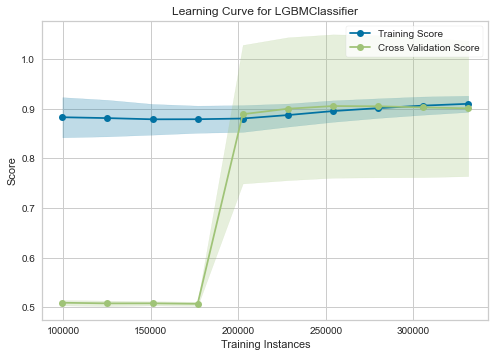

In [46]:
plot_model(estimator = tuned_lightgbm, plot = 'learning')

#### AUC Curve

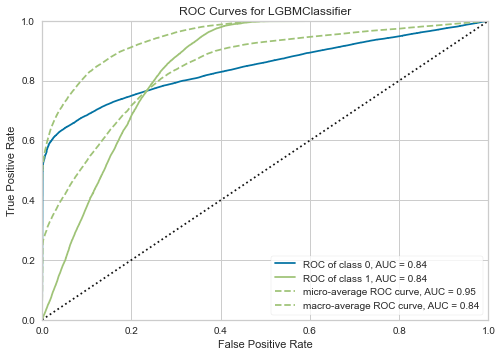

In [47]:
plot_model(estimator = tuned_lightgbm, plot = 'auc')

#### Confusion Matrix

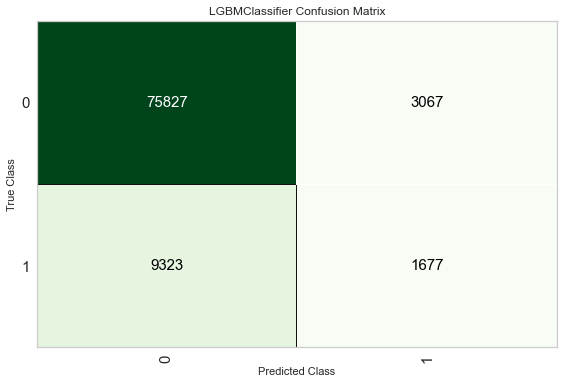

In [48]:
plot_model(estimator = tuned_lightgbm, plot = 'confusion_matrix')

#### Feature Importance

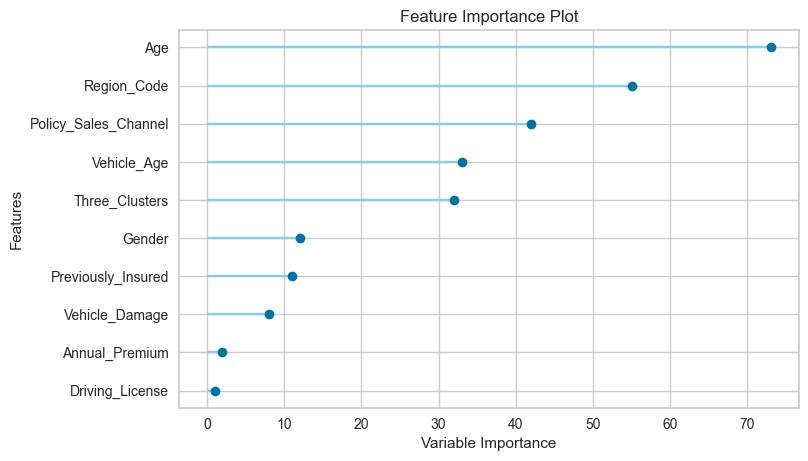

In [49]:
plot_model(estimator = tuned_lightgbm, plot = 'feature')

#### Interpret Model

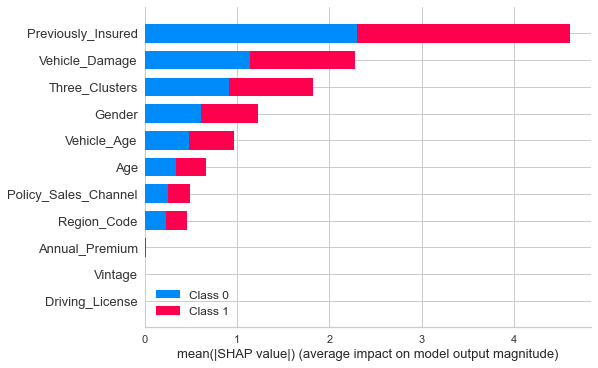

In [51]:
interpret_model(tuned_lightgbm)

Significant variables to interpret include 'Previously Insured', 'Vehicle Damage', 'Gender' and 'Age'.

#### Interpret Variables, Customers that ARE interested

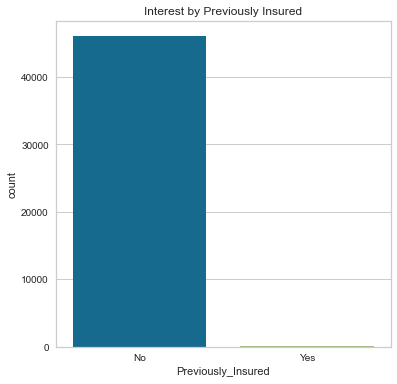

In [61]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(data=df[df['Response']!=0],x='Previously_Insured');
plt.title('Interest by Previously Insured');
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()
# fig.savefig('prev_ins.jpg',dpi=200,bbox_inches='tight')

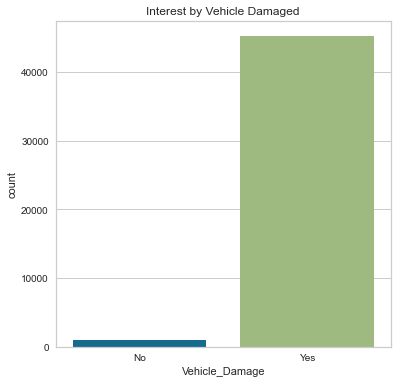

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(data=df[df['Response']!=0],x='Vehicle_Damage');
plt.title('Interest by Vehicle Damaged');
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()
# fig.savefig('veh_dam.jpg',dpi=200,bbox_inches='tight')

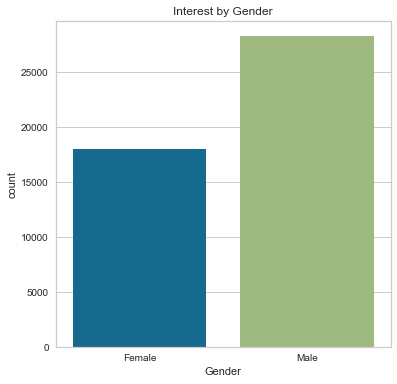

In [63]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(data=df[df['Response']!=0],x='Gender');
plt.title('Interest by Gender');
plt.xticks(ticks=[0,1], labels=['Female', 'Male'])
plt.show()
# fig.savefig('genderstat.jpg',dpi=200,bbox_inches='tight')

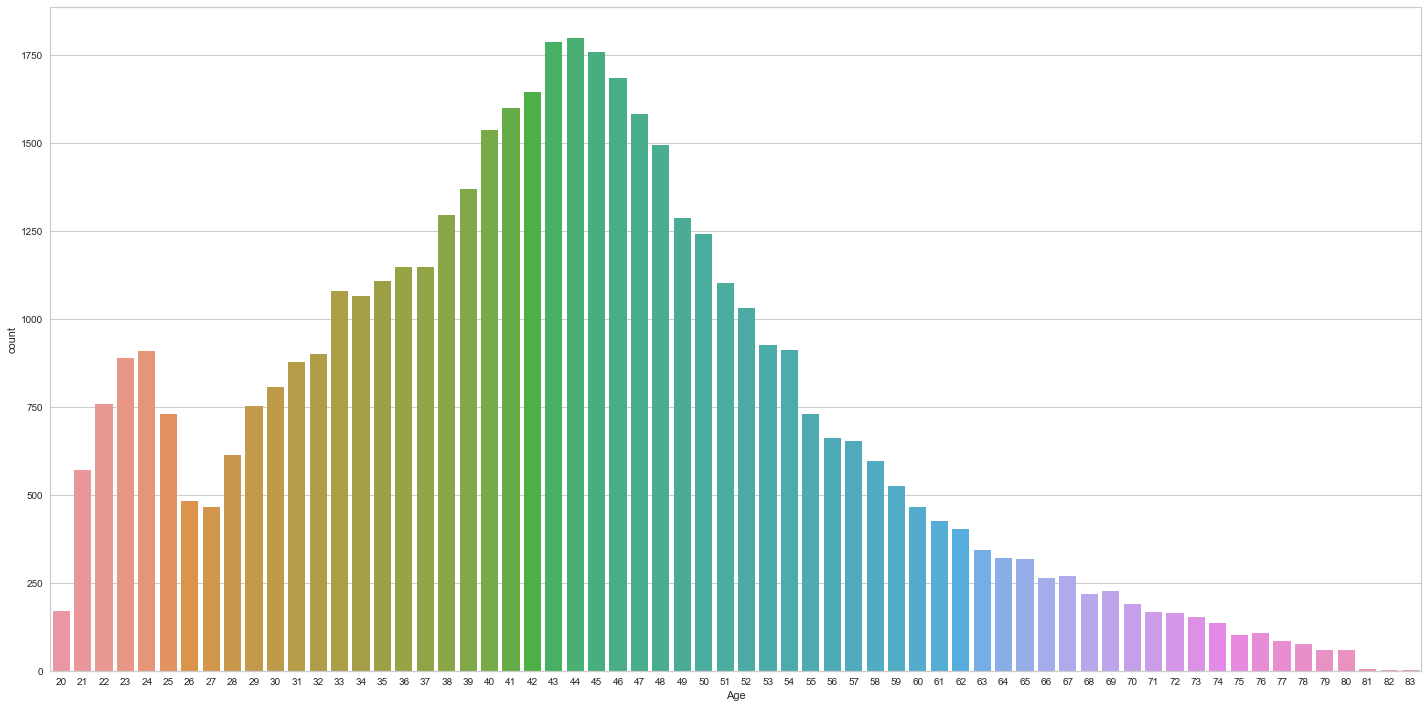

In [64]:
fig, ax =plt.subplots(figsize=(20,10))
sns.countplot(data=df[df['Response']!=0],x='Age')
plt.tight_layout()
# fig.savefig('agestat.jpg',dpi=200,bbox_inches='tight')

## Conclusion
When considering cross selling opportunities, the client should focus on marketing to customers between the ages of 35 and 50 that have not been previously insured and currently have a damaged vehicle with an emphasis on male customers.

## Future Work
This analysis does not interpret whether this specific demographic is a good insurable risk. Future work should include underwriting and rating guidelines to appropriately measure risk and price premiums for a full product analysis in these specific markets.  

For any additional questions, please reach out via email at santana2.miguel@gmail.com or on [LinkedIn.](https://www.linkedin.com/in/miguel-angel-santana-ii-mba-51467276/)